In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport  # Ensure ydata-profiling is installed

# Paths
data_dir = "Jun 12"                    # directory containing session sub-folders
output_dir = "eda_output_results"      # directory to save merged data and reports
os.makedirs(output_dir, exist_ok=True)

# Optional: define file name patterns
metadata_filename = "Metadata.csv"
merged_suffix = "_merged.csv"


c:\Anaconda\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
def load_session_data(session_path):
    """Load all sensor CSV files in a session directory (exclude metadata). 
    Return a dict of DataFrames keyed by sensor name, with columns renamed by sensor."""
    files = [f for f in os.listdir(session_path) if f.lower().endswith(".csv")]
    sensor_files = [f for f in files if f.lower() != metadata_filename.lower()]
    sensor_data = {}
    for fname in sensor_files:
        file_path = os.path.join(session_path, fname)
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"!!! Could not read {fname}: {e}")
            continue
        # Identify sensor name from file (without extension) for labeling
        sensor_name = os.path.splitext(fname)[0]
        # Identify the timestamp column (assume any column name containing "time")
        time_cols = [col for col in df.columns if "time" in col.lower()]
        time_col = time_cols[0] if time_cols else df.columns[0]  # default to first column if not found
        # Rename measurement columns to include sensor prefix
        for col in df.columns:
            if col == time_col:
                continue
            df.rename(columns={col: f"{sensor_name}_{col}"}, inplace=True)
        sensor_data[sensor_name] = df
    return sensor_data

def check_alignment(sensor_data):
    """Check which sensors have perfectly matching timestamps. 
    Returns (aligned_list, misaligned_list)."""
    if not sensor_data:
        return [], []
    # Use the first sensor as reference timeline
    ref_name = list(sensor_data.keys())[0]
    ref_df = sensor_data[ref_name].copy()
    # Ensure reference data is sorted by time
    time_col = [col for col in ref_df.columns if "time" in col.lower()][0]
    ref_df.sort_values(by=time_col, inplace=True, ignore_index=True)
    ref_times = ref_df[time_col].values
    aligned = [ref_name]
    misaligned = []
    for name, df in sensor_data.items():
        if name == ref_name:
            continue
        # Sort by time and compare timestamp arrays to reference
        df_sorted = df.sort_values(by=time_col, inplace=False, ignore_index=True)
        times = df_sorted[time_col].values
        if len(times) == len(ref_times) and np.array_equal(times, ref_times):
            aligned.append(name)
        else:
            misaligned.append(name)
    return aligned, misaligned

def merge_aligned_data(sensor_data, aligned_sensors):
    """Merge DataFrames of aligned sensors on the timestamp column (inner join)."""
    if not aligned_sensors:
        return pd.DataFrame()  # no data to merge
    # Start with the reference sensor DataFrame
    ref_name = aligned_sensors[0]
    merged_df = sensor_data[ref_name].copy()
    time_col = [col for col in merged_df.columns if "time" in col.lower()][0]
    # Merge each additional aligned sensor DataFrame on timestamp
    for name in aligned_sensors[1:]:
        merged_df = merged_df.merge(sensor_data[name], on=time_col, how='inner')
    # Sort by time in case merging disrupted order, then reset index
    merged_df.sort_values(by=time_col, inplace=True, ignore_index=True)
    return merged_df

def generate_profile_report(df, output_path):
    """Generate and save a ydata-profiling HTML report for the DataFrame."""
    profile = ProfileReport(df, title=f"Profiling Report", explorative=True)
    profile.to_file(output_path)  # Save report to HTML file:contentReference[oaicite:2]{index=2}


In [ ]:
# List all session directories in the data directory
sessions = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

print(f"Found {len(sessions)} sessions: {sessions}\n")
for session in sessions:
    session_path = os.path.join(data_dir, session)
    print(f"--- **Processing {session}**")
    # 1. Load sensor data for the session
    sensor_data = load_session_data(session_path)
    if not sensor_data:
        print("  - No sensor data files found, skipping this session.")
        continue
    # 2. Check timestamp alignment across sensors
    aligned_sensors, misaligned_sensors = check_alignment(sensor_data)
    print(f"  - Perfectly aligned sensors: {aligned_sensors}")
    print(f"  - Misaligned sensors: {misaligned_sensors}")
    # 3. Merge aligned sensor data on timestamp
    merged_df = merge_aligned_data(sensor_data, aligned_sensors)
    if merged_df.empty:
        print("  !!! No sensors were aligned. Skipping merge and profiling for this session.\n")
        continue
    # (Optional) Convert timestamp to relative time in seconds for easier analysis
    time_col = [col for col in merged_df.columns if "time" in col.lower()][0]
    # Determine timestamp unit (ms or ns) and convert to seconds
    if merged_df[time_col].iloc[0] > 1e15:
        # Likely nanoseconds since epoch:contentReference[oaicite:4]{index=4}
        merged_df['time_sec'] = (merged_df[time_col] - merged_df[time_col].min()) / 1e9
    else:
        # Likely milliseconds since epoch
        merged_df['time_sec'] = (merged_df[time_col] - merged_df[time_col].min()) / 1e3
    # Save merged data to CSV
    merge_csv_path = os.path.join(output_dir, f"{session}{merged_suffix}")
    merged_df.to_csv(merge_csv_path, index=False)
    print(f"  - Merged data saved to {merge_csv_path} (shape: {merged_df.shape})")
    # 4. Generate and save profiling report
    profile_path = os.path.join(output_dir, f"{session}_profile.html")
    generate_profile_report(merged_df, profile_path)
    print(f"  - Profiling report saved to {profile_path}\n")


Found 3 sessions: ['Spoorslag_21-2025-06-12_15-43-01', 'Vrije_Universiteit-2025-06-12_10-42-05', 'Vrije_Universiteit-2025-06-12_18-45-53']

🔷 **Processing Spoorslag_21-2025-06-12_15-43-01**
!!! Could not read Annotation.csv: No columns to parse from file
  - Perfectly aligned sensors: ['Accelerometer', 'Gravity', 'Gyroscope', 'Magnetometer', 'Orientation']
  - Misaligned sensors: ['AccelerometerUncalibrated', 'GyroscopeUncalibrated', 'HeartRate', 'Location', 'MagnetometerUncalibrated', 'Pedometer', 'WatchBarometer', 'WristMotion']
  - Merged data saved to eda_output_results\Spoorslag_21-2025-06-12_15-43-01_merged.csv (shape: (66138, 26))


Export report to file: 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]


  - Profiling report saved to eda_output_results\Spoorslag_21-2025-06-12_15-43-01_profile.html

🔷 **Processing Vrije_Universiteit-2025-06-12_10-42-05**
!!! Could not read Annotation.csv: No columns to parse from file
  - Perfectly aligned sensors: ['Accelerometer', 'Gravity', 'Gyroscope', 'Magnetometer', 'Orientation']
  - Misaligned sensors: ['AccelerometerUncalibrated', 'GyroscopeUncalibrated', 'HeartRate', 'Location', 'MagnetometerUncalibrated', 'Pedometer', 'WatchBarometer', 'WristMotion']
  - Merged data saved to eda_output_results\Vrije_Universiteit-2025-06-12_10-42-05_merged.csv (shape: (81964, 26))


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 11.22it/s]


  - Profiling report saved to eda_output_results\Vrije_Universiteit-2025-06-12_10-42-05_profile.html

🔷 **Processing Vrije_Universiteit-2025-06-12_18-45-53**
!!! Could not read Annotation.csv: No columns to parse from file
  - Perfectly aligned sensors: ['Accelerometer', 'Gravity', 'Gyroscope', 'Magnetometer', 'Orientation']
  - Misaligned sensors: ['AccelerometerUncalibrated', 'GyroscopeUncalibrated', 'HeartRate', 'Location', 'MagnetometerUncalibrated', 'Pedometer', 'WatchBarometer', 'WristMotion']
  - Merged data saved to eda_output_results\Vrije_Universiteit-2025-06-12_18-45-53_merged.csv (shape: (64724, 26))


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 10.97it/s]

  - Profiling report saved to eda_output_results\Vrije_Universiteit-2025-06-12_18-45-53_profile.html



In [9]:
# Gather all merged session files and concatenate into one DataFrame
merged_files = [f for f in os.listdir(output_dir) if f.endswith(merged_suffix)]
all_sessions_df = []
for fname in merged_files:
    session_id = fname.replace(merged_suffix, "")
    df = pd.read_csv(os.path.join(output_dir, fname))
    df['session_id'] = session_id
    # Ensure we have a relative time column for plotting (if not already present)
    time_cols = [col for col in df.columns if "time_sec" in col or ("time" in col.lower() and "sec" in col.lower())]
    if time_cols:
        tcol = time_cols[0]
    else:
        # Create time_sec similar to above conversion
        base_time_col = [col for col in df.columns if "time" in col.lower()][0]
        if df[base_time_col].iloc[0] > 1e15:
            df['time_sec'] = (df[base_time_col] - df[base_time_col].min()) / 1e9
        else:
            df['time_sec'] = (df[base_time_col] - df[base_time_col].min()) / 1e3
        tcol = 'time_sec'
    all_sessions_df.append(df)
if not all_sessions_df:
    print("No merged session data available for cross-session analysis.")
else:
    combined_df = pd.concat(all_sessions_df, ignore_index=True)
    # 1. Compute derived metrics (acceleration and gyroscope magnitude)
    # Identify accelerometer and gyroscope column names by prefix:
    accel_cols = [c for c in combined_df.columns if "Accelerometer_" in c and any(axis in c for axis in ['x','y','z','X','Y','Z'])]
    gyro_cols  = [c for c in combined_df.columns if "Gyroscope_" in c and any(axis in c for axis in ['x','y','z','X','Y','Z'])]
    if len(accel_cols) >= 3:
        ax, ay, az = combined_df[accel_cols[0]], combined_df[accel_cols[1]], combined_df[accel_cols[2]]
        combined_df['acc_magnitude'] = np.sqrt(ax**2 + ay**2 + az**2)
    if len(gyro_cols) >= 3:
        gx, gy, gz = combined_df[gyro_cols[0]], combined_df[gyro_cols[1]], combined_df[gyro_cols[2]]
        combined_df['gyro_magnitude'] = np.sqrt(gx**2 + gy**2 + gz**2)
    # 2. Summary statistics per session
    metrics = ['acc_magnitude', 'gyro_magnitude']
    summary_list = []
    for session_id, grp in combined_df.groupby('session_id'):
        stats = {
            'session_id': session_id,
            'duration_sec': grp[tcol].max() if not grp.empty else 0,  # session duration
            # compute mean and std for available metrics
            'acc_mag_mean': grp['acc_magnitude'].mean() if 'acc_magnitude' in grp else np.nan,
            'acc_mag_std':  grp['acc_magnitude'].std() if 'acc_magnitude' in grp else np.nan,
            'gyro_mag_mean': grp['gyro_magnitude'].mean() if 'gyro_magnitude' in grp else np.nan,
            'gyro_mag_std':  grp['gyro_magnitude'].std() if 'gyro_magnitude' in grp else np.nan
        }
        summary_list.append(stats)
    summary_df = pd.DataFrame(summary_list)
    # Save summary statistics table
    summary_df.to_csv(os.path.join(output_dir, "cross_session_summary.csv"), index=False)
    display(summary_df)  # show summary table in the notebook
    # 3. Plot time-series for acceleration magnitude and gyroscope magnitude across sessions
    sns.set_style("darkgrid")
    # Plot acceleration magnitude over time for each session
    plt.figure(figsize=(8,5))
    if 'acc_magnitude' in combined_df:
        sns.lineplot(data=combined_df, x=tcol, y='acc_magnitude', hue='session_id')
        plt.title("Acceleration Magnitude over Time (per session)")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Acceleration Magnitude (m/s^2)")
        plt.legend(title="Session")
        plt.tight_layout()
        acc_plot_path = os.path.join(output_dir, "acc_magnitude_comparison.png")
        plt.savefig(acc_plot_path)
        plt.show()
    else:
        print("No acceleration magnitude data to plot.")
    # Plot gyroscope magnitude over time for each session
    plt.figure(figsize=(8,5))
    if 'gyro_magnitude' in combined_df and combined_df['gyro_magnitude'].notna().any():
        sns.lineplot(data=combined_df.dropna(subset=['gyro_magnitude']), 
                     x=tcol, y='gyro_magnitude', hue='session_id')
        plt.title("Gyroscope Magnitude over Time (per session)")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Gyroscope Angular Speed (deg/s)")
        plt.legend(title="Session")
        plt.tight_layout()
        gyro_plot_path = os.path.join(output_dir, "gyro_magnitude_comparison.png")
        plt.savefig(gyro_plot_path)
        plt.show()
    else:
        print("No gyroscope data to plot for comparison.")


,session_id,duration_sec,acc_mag_mean,acc_mag_std,gyro_mag_mean,gyro_mag_std
0,Spoorslag_21-2025-06-12_15-43-01,657.011548,7.296346,6.096584,328.610668,189.645662
1,Vrije_Universiteit-2025-06-12_10-42-05,814.139892,5.048169,3.844550,407.108702,235.019607
2,Vrije_Universiteit-2025-06-12_18-45-53,642.938607,7.451068,5.493539,321.531103,185.582683


C:\Users\liuho\AppData\Local\Temp\ipykernel_11960\936200769.py:66: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\liuho\AppData\Local\Temp\ipykernel_11960\936200769.py:81: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


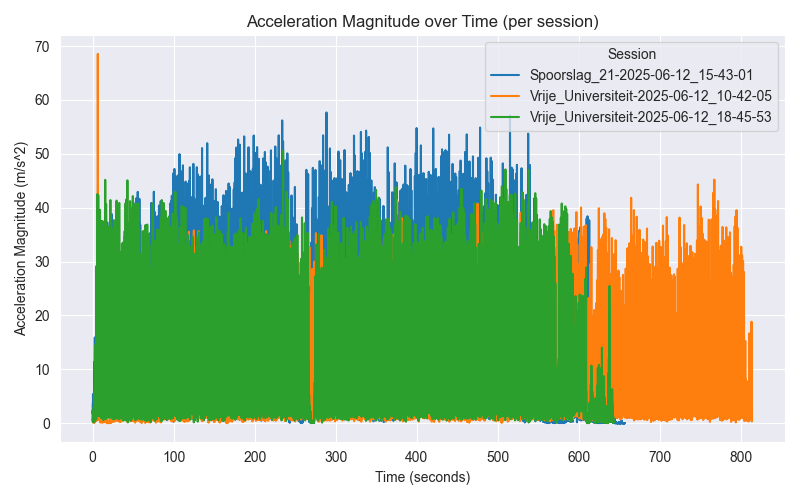

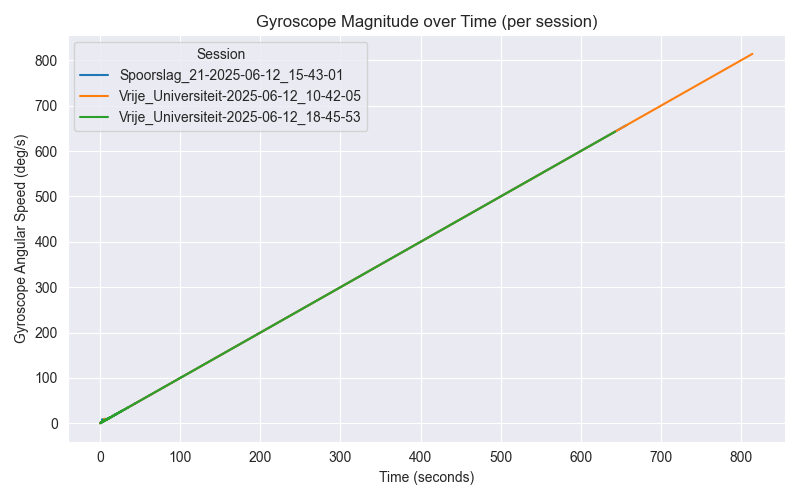

In [10]:
from IPython.display import Image, display

display(Image(filename="eda_output_results/acc_magnitude_comparison.png"))
display(Image(filename="eda_output_results/gyro_magnitude_comparison.png"))

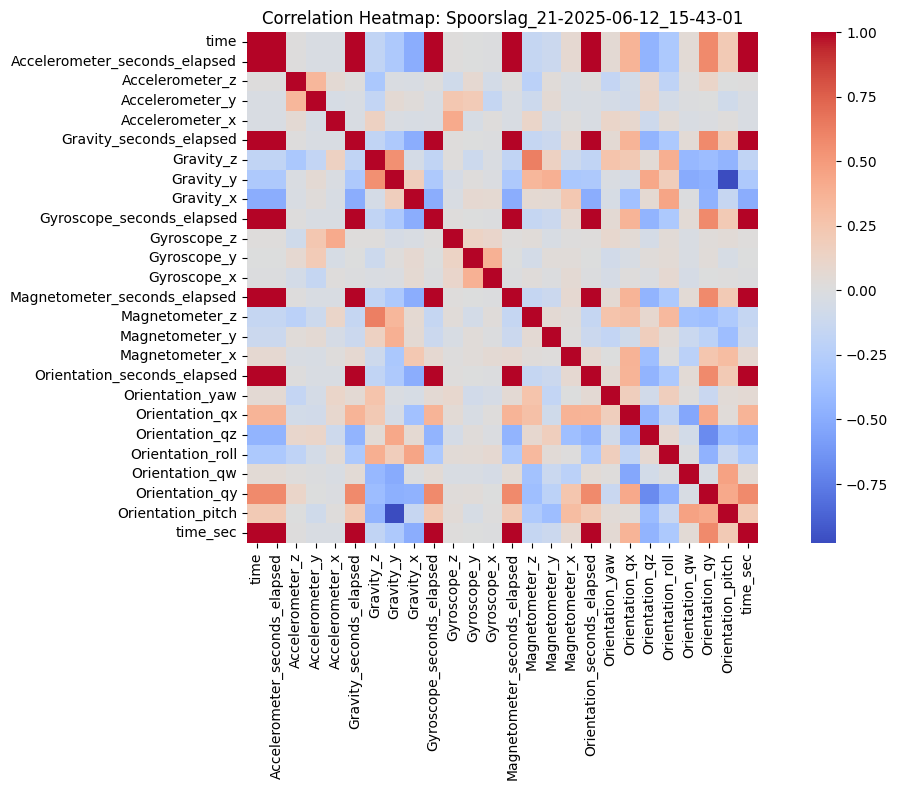

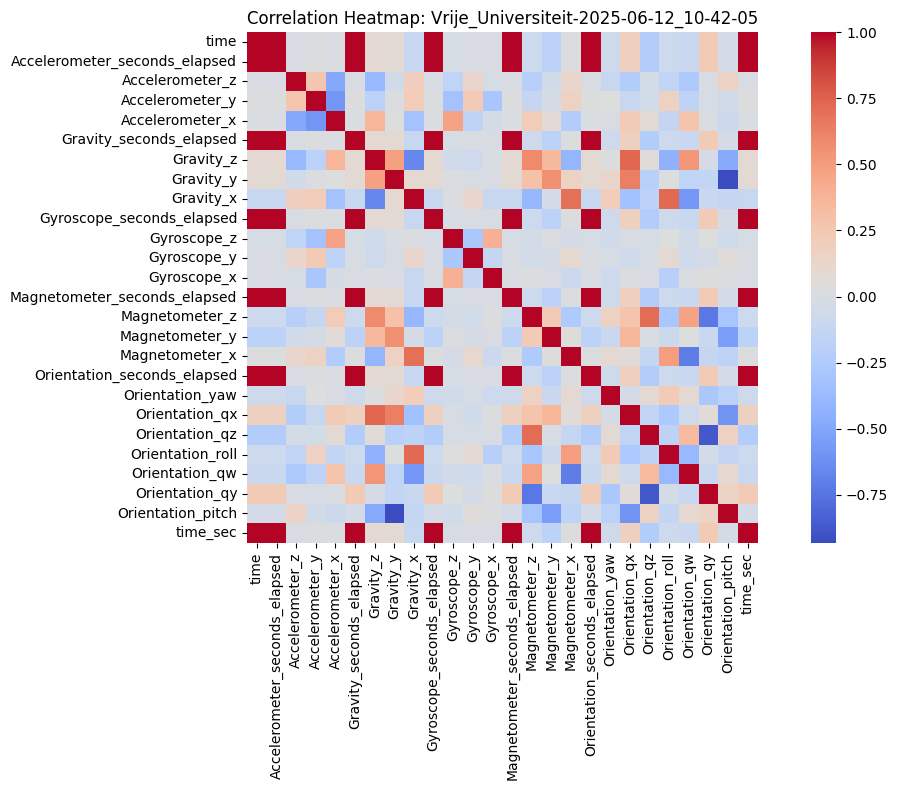

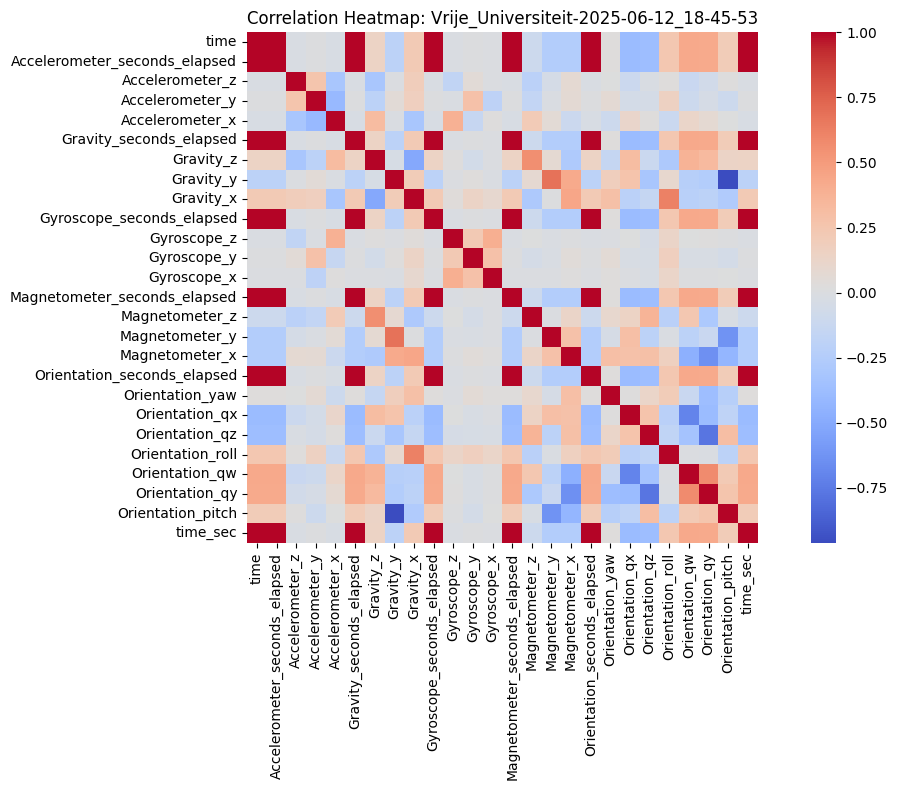

In [13]:
# Generate and display a correlation heatmap for each merged CSV file in the output directory, without showing cell values
merged_files = [f for f in os.listdir(output_dir) if f.endswith(merged_suffix)]
for fname in merged_files:
    session_id = fname.replace(merged_suffix, "")
    df = pd.read_csv(os.path.join(output_dir, fname))
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] < 2:
        print(f"Not enough numeric columns for correlation in {fname}.")
        continue
    corr = numeric_df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=False, cmap="coolwarm", square=True)
    plt.title(f"Correlation Heatmap: {session_id}")
    plt.tight_layout()
    plt.show()


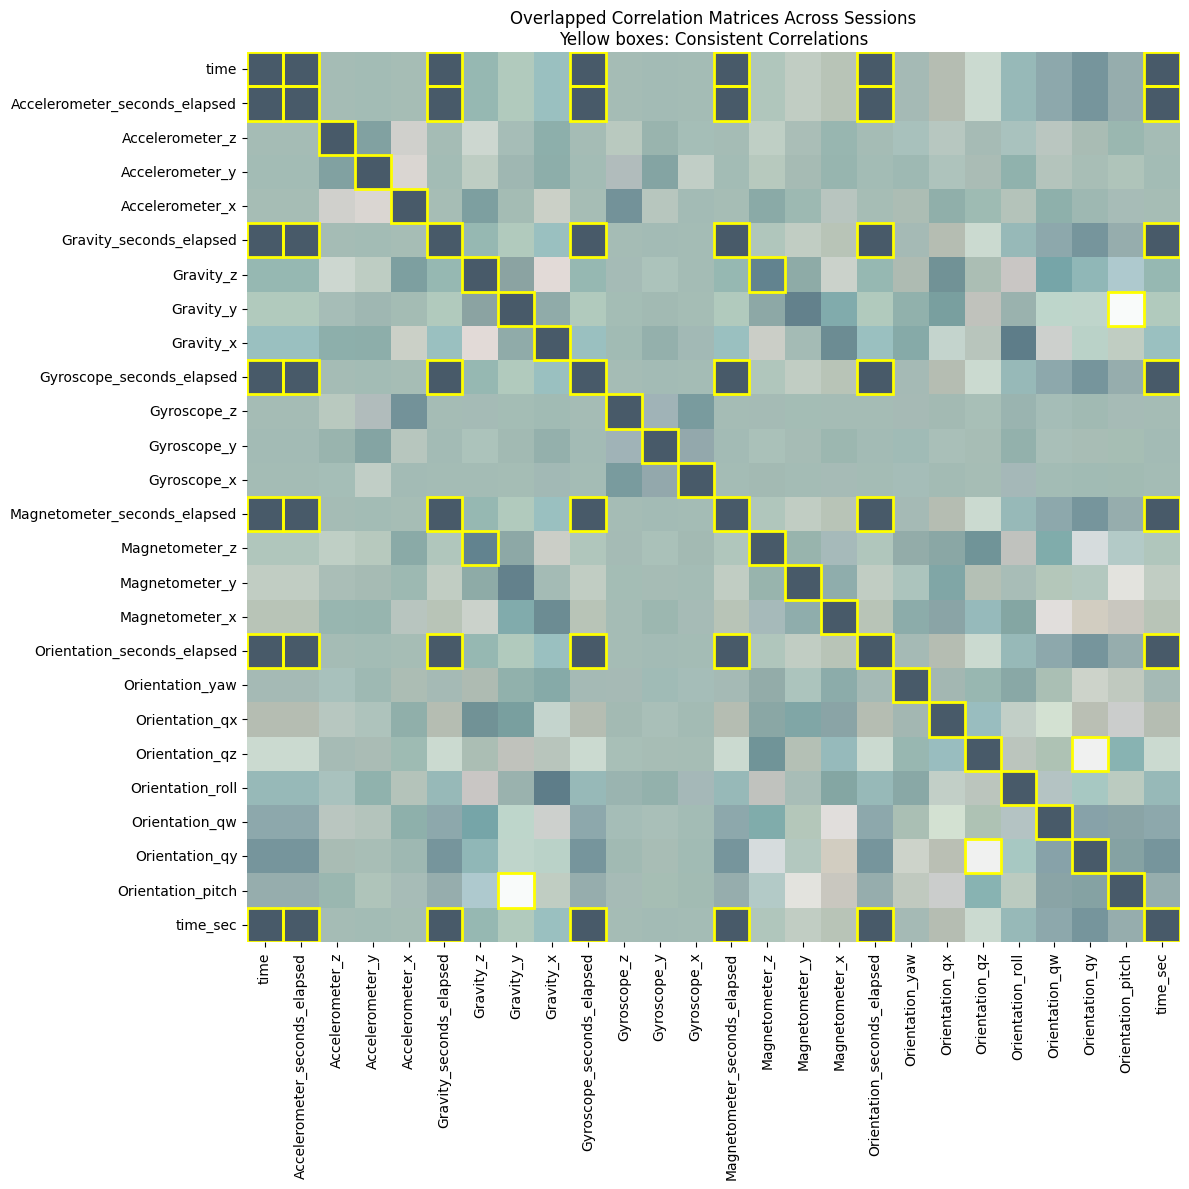

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Example: corr1, corr2, corr3 are your correlation matrices (numpy arrays or pandas DataFrames)
# Replace these with your actual data
# corr1 = ...
# corr2 = ...
# corr3 = ...
corr = []
merged_files = [f for f in os.listdir(output_dir) if f.endswith(merged_suffix)]
for fname in merged_files:
    session_id = fname.replace(merged_suffix, "")
    df = pd.read_csv(os.path.join(output_dir, fname))
    # Select only numeric columns for correlation
    numeric_df = df.select_dtypes(include=[np.number])
    if numeric_df.shape[1] < 2:
        print(f"Not enough numeric columns for correlation in {fname}.")
        continue
    corr.append(numeric_df.corr())

fig, ax = plt.subplots(figsize=(12, 12))

# Plot each correlation matrix with some transparency
if len(corr) >= 1:
    sns.heatmap(corr[0], ax=ax, cmap='Reds', alpha=0.4, cbar=False, annot=False)
if len(corr) >= 2:
    sns.heatmap(corr[1], ax=ax, cmap='Greens', alpha=0.4, cbar=False, annot=False)
if len(corr) >= 3:
    sns.heatmap(corr[2], ax=ax, cmap='Blues', alpha=0.4, cbar=False, annot=False)

# Highlight cells with consistent high correlation across all sessions
# For example, highlight if all three correlations > 0.5
threshold = 0.5
if len(corr) >= 3:
    consistent = (np.abs(corr[0]) > threshold) & (np.abs(corr[1]) > threshold) & (np.abs(corr[2]) > threshold)
    for i in range(corr[0].shape[0]):
        for j in range(corr[0].shape[1]):
            if consistent.iloc[i, j]:
                ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=False, edgecolor='yellow', lw=2))

ax.set_title('Overlapped Correlation Matrices Across Sessions\nYellow boxes: Consistent Correlations')
plt.tight_layout()
plt.show()